<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_87~95%2C_105~115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. 모델 세부 설정

In [1]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print("train set: ", x_train.shape, y_train.shape)
print("test setL ", x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train / x_train.max()   # max: 255
x_test = x_test / x_test.max()    # max: 255

11490434/11490434 [==============================] - 0s 0us/step
train set:  (60000, 28, 28) (60000,)
test setL  (10000, 28, 28) (10000,)


## 4-1 초기값 설정
* Dense 레이어는 기본 초기화 방법으로 Glorot Uniform 초기화 방법이 설정되어 있음.

In [2]:
dense = tf.keras.layers.Dense(256, activation = "relu")
dense.get_config()["kernel_initializer"]

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

* 기본값으로 설정된 Glorot Uniform 초기화 방법을 HeNormal로 변경하기 위해서는 kernel_initializer 매개변수에 설정하면 됨
* 옵티마이저, 손실함수와 마찬가지로 문자열로 지정하는 방법과 클래스 인스턴스로 지정하는 방법이 있음.

In [3]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer = "he_normal", activation = "relu")
print(dense.get_config()["kernel_initializer"])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer = he_normal, activation = "relu")
print(dense.get_config()["kernel_initializer"])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}
{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


* 케라스에서 지원하는 자주 사용되는 초기화 목록
 * "glorot_normal", "glorot_uniform": 글로럿 초기화(Xavier 초기화)
 * "lecun_normal", "lecun_uniform": Yann Lecun 초기화
 * "he_normal", "he_uniform": HE 초기화
 * "random_normal", "random_uniform": 정규 분포, 연속균등 분포 초기화

## 4-2 규제(Regularization)
* 모델의 과대적합을 해소하기 위해 L1, L2 규제를 적용하기도 함.
* 텐서플로 케라스 레이어는 기본값으로 규제를 적용하지 않고 있음. 따라서 레이어 규제를 적용하기 위해서는 별도로 설정해 주어야 함.

In [4]:
# 기본값
desne = tf.keras.layers.Dense(256, activation = "relu")
dense.get_config()

{'name': 'dense_2',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'HeNormal',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

* 모델이 과대적합하는 것을 방지해 주기 위해 모델을 구성하는 레이어마다 규제를 적용할 수 있음.
* 케라스에서 지원하는 규제는 L1, L2 규제가 있음.
* 규제를 적용하기 위해서는 kernel_regularizer에 규제를 지정

In [5]:
# l1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer = "l1", activation = "relu")
print(dense.get_config()["kernel_regularizer"])

# 클래스 인스턴스 적용. alpha = 0.1 변경
regularizer = tf.keras.regularizers.l1(l1 = 0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer = regularizer, activation = "relu")
print(dense.get_config()["kernel_regularizer"])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.009999999776482582}, 'registered_name': None}
{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.10000000149011612}, 'registered_name': None}


## 4-3 드롭아웃(Dropout)
* 딥러닝 모델의 가장 큰 난제가 바로 과대적합 문제
* 딥러닝 모델의 층이 넓고 깊어질 때 모델은 훈련에 주어진 샘플에 과하게 적합하도록 학습하는 경향이 있음.
* 따라서 훈련할 때 만나지 못한 새로운 데이터에 대해서는 좋지 않은 예측력을 보일 때가 많음.
* 즉, 훈련 데이터셋에 너무 적응하여 검증 데이터셋이나 테스트 데이터셋에 대해 일반화된 성능을 갖지 못하는 문제가 자주 발생하는 편.
* 드롭아웃은 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어이며, 실무적으로 상당히 좋은 효과를 보이는 것으로 알려져 있음.

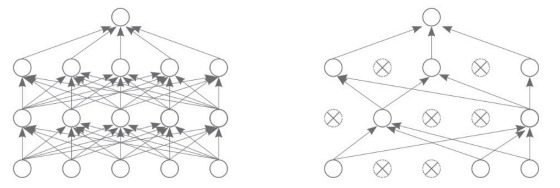



* 왼쪽 그림을 보면 모든 노드들이 연결되어 있지만, 오른쪽 그림은 모든 노드가 연결되어 있지 않고 확률적으로 몇 개의 신호는 끊겨 있음.
* 이렇게 노드의 일부 신호를 임의로 삭제하게 되면, 모델이 쉽게 과대적합 되는 것을 방지할 수 있음. 모델이 학습하는 가중치 파라미터의 개수가 현저하게 줄어들기 때문.
* 중요한 점은 모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 훈련하게 되지만, 예측 시점에는 모든 노드들이 활용됨.


In [6]:
# Dropout 25% 비율 적용(25%의 노드가 삭제)
tf.keras.layers.Dropout(0.25)

## 4-4 배치 정규화(Batch Normalization)
* 배치 정규화: 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화
* 다음 층으로 데이터가 전달되기 전에 스케일을 조정하기 때문에 보다 안정적인 훈련이 가능하고 성능을 크게 향상시킬 수 있음.
* 배치 정규화 층은 케라스에서 클래스 함수로 지원하기 때문에 별도로 코드를 구현할 필요가 없고, 클래스 인스턴스를 생성하여 추가해주면 됨.

In [7]:
# model A: Dense + ReLU
model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax"),
])
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 52650 (205.66 KB)
Trainable params: 52650 (205.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(10, activation = "softmax")
])
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                     

* 동일한 조건에서 10번의 epoch동안 model_a, model_b 두 모델을 훈련한 결과는 다음과 같음.

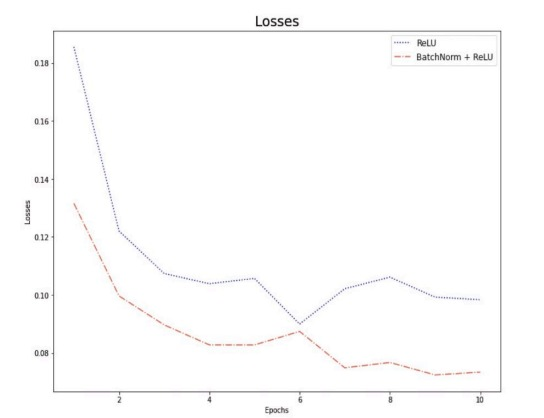

* 배치 정규화만 추가하였는데 손실은 이전 대비 더 안정적이고 빠르게 수렴하는 것을 확인할 수 있음.
* 데이터 개수가 적은 편인 mnist 손글씨 데이터셋에서는 큰 차이를 보이지 않을 수 있지만, 더 크고 복잡한 데이터셋에 대해서는 배치 정규화 유무가 모델 성능에 크게 영향을 미치는 경우도 있으므로 배치 정규화를 적극 적용해 볼 필요가 있음.

## 4-5 활성화(activation) 함수
* 케라스가 지원하는 다른 활성화 함수를 적용해 볼 수 있음.

In [9]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha = 0.2로 변경
tf.keras.layers.LeakyReLU(alpha = 0.2)

In [10]:
# Model C: Dense + BatchNorm + LeakyReLU(0.2)
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha = 0.2 적용
    tf.keras.layers.LeakyReLU(alpha = 0.2),

    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha = 0.2 적용
    tf.keras.layers.LeakyReLU(alpha = 0.2),

    tf.keras.layers.Dense(10, activation = "softmax")
])

# 모델 요약
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                     

* 앞에서 생성한 2개의 모델과 LeakyReLU 활성화 함수로 변경한 모델까지 더해서 총 3개의 모델을 동일한 조건으로 10번의 epoch 동안 훈련한 후에 수렴 속도를 확인
 * model_a: Dense 레이어 + ReLU 활성화 함수
 * model_b: Dense 레이어 + 배치 정규화
 * model_c: Dense 레이어 + 배치 정규화 + LeakyReLU(0, 2) 활성화 함수

In [11]:
model_a.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_b.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_c.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# Mdoel A: Dense + ReLU
history_a = model_a.fit(x_train, y_train,
                        validation_data = (x_test, y_test),
                        epochs = 10)

# Model B: Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train,
                        validation_data = (x_test, y_test),
                        epochs = 10)

# Model C: Dense + BatchNorm + LeakyReLU(0, 2)
history_c = model_c.fit(x_train, y_train,
                        validation_data = (x_test, y_test),
                        epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2938 - accuracy: 0.9169 - val_loss: 0.1723 - val_accuracy: 0.9486
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1396 - accuracy: 0.9576 - val_loss: 0.1210 - val_accuracy: 0.9622
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1002 - accuracy: 0.9700 - val_loss: 0.1057 - val_accuracy: 0.9683
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0800 - accuracy: 0.9755 - val_loss: 0.0968 - val_accuracy: 0.9702
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0654 - accuracy: 0.9799 - val_loss: 0.1040 - val_accuracy: 0.9683
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0571 - accuracy: 0.9822 - val_loss: 0.0986 - val_accuracy: 0.9700
Epoch 7/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0477 - accuracy: 0.9850 - val_loss: 0.0869 - val_accu

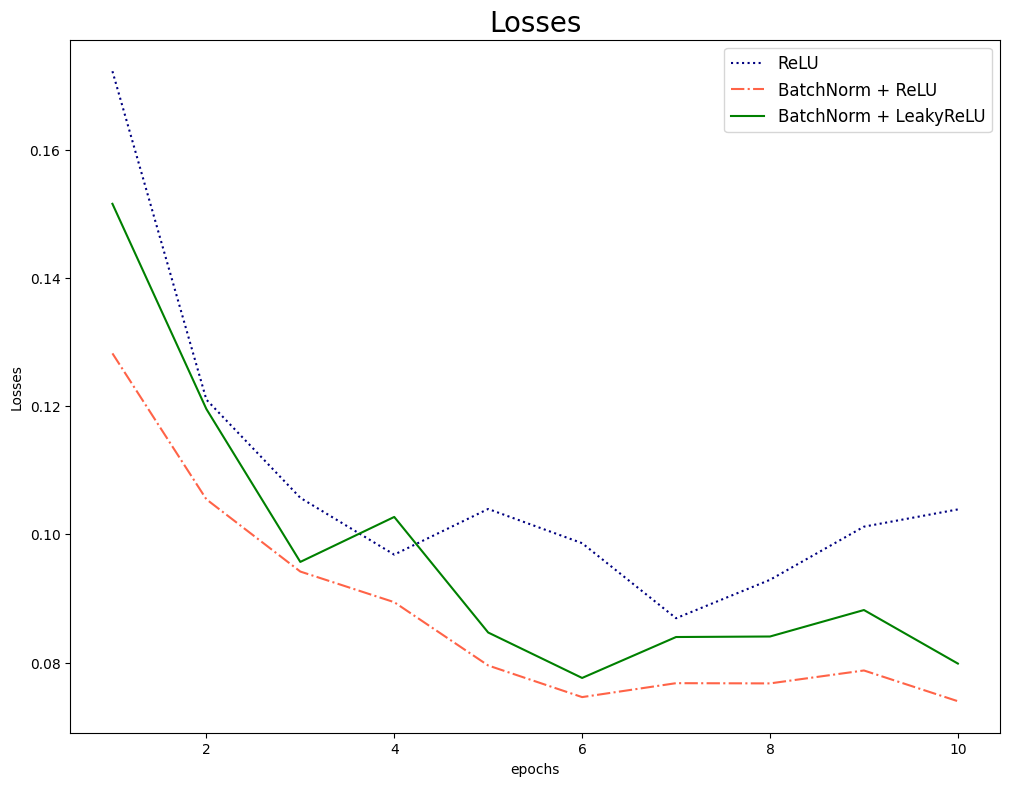

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (12, 9))
plt.plot(np.arange(1, 11), history_a.history["val_loss"], color = "navy", linestyle = ":")
plt.plot(np.arange(1, 11), history_b.history["val_loss"], color = "tomato", linestyle = "-.")
plt.plot(np.arange(1, 11), history_c.history["val_loss"], color = "green", linestyle = "-")

plt.title("Losses", fontsize = 20)
plt.xlabel("epochs")
plt.ylabel("Losses")
plt.legend(["ReLU", "BatchNorm + ReLU", "BatchNorm + LeakyReLU"], fontsize = 12)
plt.show()

* mnist 데이터셋은 모델별 차이가 크지는 않으나, 좀 더 복잡한 데이터셋을 다룬다면 배치 정규화와 다른 활성화 함수를 적용해 보면서 모델의 훈련 추이를 관찰해 볼 필요가 있음.

# 06. 모델 저장 및 불러오기

## 6-1 모델을 파일로 저장
* 훈련을 종료하여 가중치가 업데이트된 모델 인스턴스를 저장할 수 있음.
* save() 메소드를 사용하는데, save() 메소드를 호출할 때 저장할 파일의 디렉토리를 포함하는 파일명을 매개변수로 지정
* 모델을 저장하는 형식은 HDF5 포맷과 SavedModel 포맷 두 가지가 있음.
* 모델을 저장할 파일명이 .h5 확장자를 포함하는 경우는 모델이 HDF5 포맷으로 저장
* HDF5 파일 형식은 대용량의 데이터를 저장하기 위한 파일 형식

In [13]:
# 모델을 h5 포맷으로 저장
model_b.save("h5-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6-2 저장된 모델 복원
* tensorflow.keras.models.load_model() 메소드로 저장된 모델을 복원할 수 있음.

In [14]:
# 모델 복원
h5_model = tf.keras.models.load_model("h5-model.h5")
h5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                     

* 검증 셋을 evalueate 함수에 대입해, 손실 함수와 평가지표를 계산

In [15]:
# 모델 검증
loss, acc = h5_model.evaluate(x_test, y_test, verbose = 0)
print(f"h5 model] loss: {loss:.5f}, acc: {acc:.5f}")

h5 model] loss: 0.07396, acc: 0.97840


* .h5 확장자를 생략하면 SavedModel 포맷으로 저장되며 텐서플로2에서 기본으로 지원하는 파일 포맷
* SavedModel 포맷으로 저장된 모델을 복원할 때 HDF5와 같은 방식으로 복원하면 됨.

In [16]:
# 모델을 SavedModel 포맷으로 저장
model_b.save("saved-model")

* SavedModel 포맷으로 저장된 모델을 복원하여 summary()를 확인

In [17]:
# 모델 복원
saved_model = tf.keras.models.load_model("saved-model")
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                     

* SavedModel 형식으로 저장 및 복원된 모델의 성능을 확인하면, HDF5 형식으로 저장 및 복원된 모델과 동일한 성능을 나타냄

In [18]:
# 모델 검증(HDF5 포맷)
loss, acc = h5_model.evaluate(x_test, y_test, verbose = 0)
print(f"5h model] loss: {loss:.5f}, acc: {acc:.5f}")

# 모델 검증(SavedModel 포맷)
loss, acc = saved_model.evaluate(x_test, y_test, verbose = 0)
print(f"saved model] loss: {loss:.5f}, acc: {acc:.5f}")

5h model] loss: 0.07396, acc: 0.97840
saved model] loss: 0.07396, acc: 0.97840


# 07. 복잡한 모델 생성

## 7-1 함수형 API(Functional API)
* 여러 층을 시퀀스 형태로 연결하는 Sequential API와 다르게, Functional API는 복잡한 구조의 모델을 정의할 수 있음.

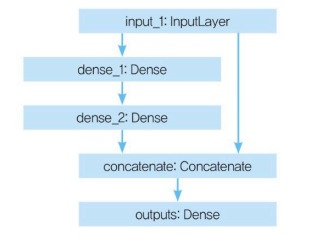

* 함수의 입력 매개변수를 여러 개 갖는 다중 입력, 함수의 return 값을 여러 개 갖는 다중 출력, 같은 레벨에 여러 개의 층을 배치하여 입력과 출력을 공유하는 구조도 가능.
* Sequential API를 사용하는 경우 단방향의 Sequential 모델만 구현할 수 있다는 제약이 있음. 데이터의 흐름이 특정 레이어를 건너뛰거나, 병합 및 분리하는 등의 구조의 모델을 구현할수는 없음.
* 함수형 API를 사용하기 위해서는 Input 레이어에 입력 shape를 정의. 레이어마다 반환되는 출력 값을 변수에 저장한 뒤 다음 레이어의 입력으로 연결. 이렇게 여러 개의 레이어를 마치 체인 구조로 입출력을 계속 연결할 수 있음.

In [19]:
# 모델의 레이어를 체인 구조로 연결 Input 레이어 정의
input_layer = tf.keras.Input(shape = (28, 28), name = "InputLayer")

# 모델의 레이어를 체인 구조로 연결
x1 = tf.keras.layers.Flatten(name = "Flatten")(input_layer)
x2 = tf.keras.layers.Dense(256, activation = "relu", name = "Dense1")(x1)
x3 = tf.keras.layers.Dense(64, activation = "relu", name = "Dense2")(x2)
x4 = tf.keras.layers.Dense(10, activation = "softmax", name = "OutputLayer")(x3)

* 레이어마다 name 매개변수로 이름을 부여할 수 있음. 모델 인스턴스에 대하여 summary()로 요약 출력할 때 이름이 함께 출력됨.
* 첫 Input 레이어로 시작하여 x4 변수는 마지막 출력층을 나타냄.
* 이렇게 체인 방식으로 연결한 후에 tf.keras.Model()에 입력 레이어와 출력 레이어를 정의해 모델을 생성

In [20]:
# 모델 생성
func_model = tf.keras.Model(inputs = input_layer, outputs = x4, name = "FunctionalModel")

# 모델 요약
func_model.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               200960    
                                                                 
 Dense2 (Dense)              (None, 64)                16448     
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* tf.keras.Model()에 inputs 매개변수로 입력층인 input_layer를 지정하고 outputs 매개변수에 출력층을 지정해주어 모델을 생성.
* 모델 인스턴스 생성 시 name 매개변수에 이름을 저장하면 해당 이름이 summary()에 출력됨.
* 지금까지는 summary()로 모델의 요약을 확인했지만, 복잡한 구조를 갖는 모델을 생성할 때 summary()로는 모델의 구조도를 시각화하기 어려움.
* 케라스의 유틸 패키지에서 제공하는 plot_model 모듈을 활용하여 모델의 구조도를 시각화할 수 있음.

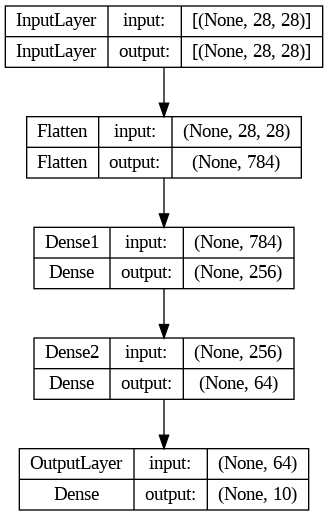

In [22]:
from tensorflow.keras.utils import plot_model

# 구조도 시각화
plot_model(func_model, show_shapes = True, show_layer_names = True, to_file = "model.png")

* plot_model()에 모델을 지정하면 구조도가 출력됨.
* show_shapes = True로 지정하면 데이터의 입출력 shape를 출력하고, show_layer_names = True로 지정하면 레이어의 이름을 출력.
* 시각화한 구조도를 to_file 매개변수에 파일명을 입력하면 이미지 파일 저장도 가능함.
* 함수형 API로 생성한 모델도 Sequential API로 생성한 모델과 동일한 방식으로 훈련할 수 있음.
* 생성된 모델 인스턴스에 compile() 메소드로 모델을 컴파일하고 fit() 메소드로 모델을 훈련.
* 훈련이 완료된 뒤 evaluate() 메소드로 검증할 수 있음.

In [24]:
# 컴파일
func_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                   metrics = ["accuracy"])

# 훈련
func_model.fit(x_train, y_train, epochs = 3)

# 검증
loss, acc = func_model.evaluate(x_test, y_test, verbose = 0)
print(f"Functional Model] loss: {loss:.5f}, acc: {acc:.5f}")

Epoch 1/3
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2143 - accuracy: 0.9361
Epoch 2/3
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0882 - accuracy: 0.9735
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0599 - accuracy: 0.9809
Functional Model] loss: 0.07567, acc: 0.97670


## 7-2 모델 서브클래싱 (Model Subclassing)
* 텐서플로 케라스는 Model 클래스를 제공하고, 이를 기반으로 딥러닝 모델을 구현. 이 클래스를 직접 상속받아 사용자가 직접 서브클래스로 딥러닝 모델을 만들 수도 있음.

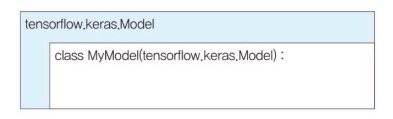

* 객체지향이나 파이썬 클래스의 개념이 부족하다면 굳이 Model Subclassing으로 모델을 구현하지 않아도 좋음.
* 함수형 API로 생성한 모델과의 성능 차이는 없으며, 따라서 Sequential API과 Functional API로 충분.
>
* Model Subclassing으로 모델 인스턴스를 생성하기 위해서는 tf.keras.Model를 상속받아 생성하고자 하는 모델 클래스를 구현

In [28]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    # 초기값 설정
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(256, activation = "relu")
    self.dense2 = tf.keras.layers.Dense(64, activation = "relu")
    self.dense3 = tf.keras.layers.Dense(10, activation = "softmax")

  # method overiding
  # 훈련용 함수 정의
  # x는 input
  def call(self, x):
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

* call() 함수를 메소드 오버라이딩으로 구현
* call() 메소드는 fit() 메소드가 호출되어 훈련하는 경우 호출될 함수.
* call() 함수 내부에서는 모델의 입력부터 출력까지의 흐름, 즉 순전파를 정의하고 함수형 API와 같은 방식으로 모든 레이어를 체인처럼 연결함.
* 마지막으로 최종 출력 값을 return

In [29]:
# 모델 생성
mymodel = MyModel()

# 모델의 이름 설정
mymodel._name = "subclass_model"

# 모델의 input 정의
mymodel(tf.keras.layers.Input(shape = (28, 28)))

# 모델 요약
mymodel.summary()

Model: "subclass_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_21 (Dense)            multiple                  200960    
                                                                 
 dense_22 (Dense)            multiple                  16448     
                                                                 
 dense_23 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* tf.keras.Model을 상속받아 구현한 모델인 MyModel을 생성자로 인스턴스를 생성
* 모델에 이름을 부여하고 싶다면 모델 인스턴스의 _name에 이름을 지정
* 생성자로 객체를 생성해 저장한 mymodel 변수에 바로 summary()로 요약 출력하는 것은 불가함. input_shape이 정의되지 않았기 때문에 전체 모델의 구조를 생성해내지 못하기 때문.
* mymodel에 Input 레이어와 함께 shape을 정의해주면 summary()로 모델의 요약을 확인할 수 있음.

In [30]:
# 컴파일
mymodel.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# 훈련
mymodel.fit(x_train, y_train, epochs = 3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose = 0)
print(f"Subclassing Model] loss: {loss: .5f}, acc: {acc:.5f}")

Epoch 1/3
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2138 - accuracy: 0.9372
Epoch 2/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0901 - accuracy: 0.9725
Epoch 3/3
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0613 - accuracy: 0.9803
Subclassing Model] loss:  0.08110, acc: 0.97730


* Model Subclassing으로 생성된 모델의 훈련도 동일하게 compile() 메소드로 컴파일 후 fit() 메소드로 훈련
* 함수형 API로 생성한 모델과 Model Subclassing으로 생성한 모델 모두 동일한 compile() 메소드와 fit() 메소드로 훈련할 수 있음
* 물론 evaluate() 메소드로 모델 성능을 검증할 수도 있음. 단지 모델을 생성하는 방식에 차이가 있을 뿐.

## 7-3 서브클래싱 모델 파라미터를 활용한 생성
* Model Subclassing으로 생성하는 장점은 생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터를 지정할 수 있다는 점

In [42]:
class MyModel(tf.keras.Model):

  # 생성자 파라미터 추가
  def __init__(self, units, num_classes):
    super(MyModel, self).__init__()
    # 초기값 설정
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units, activation = "relu")
    self.dense2 = tf.keras.layers.Dense(units/4, activation = "relu")
    self.dense3 = tf.keras.layers.Dense(num_classes, activation = "softmax")

  # class overiding
  # 훈련용 함수 정의
  # x는 input
  def call(self, x):
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

* 모델의 생성자 파라미터로 기준이 되는 unit의 개수를 입력받아 Dense 레이어의 유닛 개수를 계산하여 설정

In [43]:
# 모델 생성
mymodel = MyModel(256, 10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape = (28, 28)))

# 모델 요약
mymodel.summary()

Model: "my_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 dense_39 (Dense)            multiple                  200960    
                                                                 
 dense_40 (Dense)            multiple                  16448     
                                                                 
 dense_41 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* 모델 생성자에 생성자 파라미터로 초기화하여 생성한 모델에 summary()로 요약한 결과를 확인해보면 동적으로 설정한 레이어의 파라미터가 초기화되었음을 알 수 있음.

In [44]:
# 컴파일
mymodel.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# 훈련
mymodel.fit(x_train, y_train, epochs = 3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose = 0)
print(f"Subclassing Model w.parameters] loss: {loss:.5f}, acc: {acc:.5f}")

Epoch 1/3
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2161 - accuracy: 0.9352
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0892 - accuracy: 0.9726
Epoch 3/3
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0607 - accuracy: 0.9807
Subclassing Model w.parameters] loss: 0.09362, acc: 0.97320


* 이렇게 생성한 모델도 동일하게 compile() 메소드로 컴파일한 뒤 fit() 메소드로 훈련
* 훈련이 완료된 뒤 모델 인스턴스의 evaluate() 메소드로 모델의 성능을 검증할 수 있음.